# Application

Comparison between the UQ of the IMV against the UQ of CP under a variety of different models. 

1. Data types: tas, tasmax, pr
2. Metrics: CRPS, marginal calibration (PIT), probabilistic calibration (PIT), dispersion (PIT), sharpness
3. Models: ensemble average, NNGP, CNN, Regression

<!-- Table of comparisons showing that CP has lower CRPS, PIT, etc. scores across a variety of models, projectors, and data types (tas, tasmax, pr) -->

Also include coverage?

Message: Regardless of prediction task, CP has superior UQ, in terms of these metrics, compared with IMV

In [1]:
import os
import gc
import math

# numpy
import numpy as np
import scipy
from scipy import stats
np.set_printoptions(suppress=True)

# from jax
import jax
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.config import config
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

import haiku as hk
import flax
from flax import linen as nn
import optax

import properscoring as ps

config.update("jax_enable_x64", True)

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm.notebook import tqdm
from tqdm.notebook import trange

# netCDF
import netCDF4 as nc
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

In [2]:
import matplotlib.ticker as tkr
from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
def moving_average(a, n=12):
    a = np.array(a)
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
def scale_and_split(xtrain, xtest, ytrain, nval = 200):

    ## dimensions
    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]
    nlat = xtrain.shape[2]
    nlon = xtrain.shape[3]

    ## rescale
    xtrain_mean = np.mean(xtrain, axis = 1)
    xtest_mean = np.mean(xtest, axis = 1)
    xtrain_sd = np.std(xtrain, axis = 1)
    xtest_sd = np.std(xtest, axis = 1)

    xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
    xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
    ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd

    xval_scaled = xtrain_scaled[-nval:]
    yval_scaled = ytrain_scaled[-nval:]
    xtrain_scaled = xtrain_scaled[:-nval]
    ytrain_scaled = ytrain_scaled[:-nval]
    
    out = [xtrain_scaled, xval_scaled, xtest_scaled,
            ytrain_scaled, yval_scaled,
            xtrain_mean, xtest_mean, xtrain_sd, xtest_sd]
    return [np.float32(x) for x in out]

def anomalize(xtrain, xtest):
    xtrain_anom = np.zeros_like(xtrain)
    xtest_anom = np.zeros_like(xtest)

    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]

    monthly_means = np.array([np.mean(xtrain[(12*20):(12*50)][i::12], axis = 0) for i in range(12)])
    for k in trange(ntrain, leave = False):
        xtrain_anom[k] = xtrain[k] - monthly_means[k % 12]

    for k in trange(ntest, leave = False):
        xtest_anom[k] = xtest[k] - monthly_means[k % 12]
    
    return np.array(xtrain_anom), np.array(xtest_anom)

In [5]:
def inf_depth(x, y):
    dist = jnp.max(jnp.abs(y), axis = (1, 2))
    return 1/(1 + dist)
inf_depth = jit(inf_depth)

def global_mmd(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(dist)
    return 1/(1 + dist)
global_mmd = jit(vmap(global_mmd, (None, 0)))

def global_mmd_self(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(jnp.sort(dist)[1:])
    return 1/(1 + dist)
global_mmd_self = jit(vmap(global_mmd_self, (None, 0)))

def field_min(x, y):
    return jnp.min(jnp.array([x, y]))
field_min = jit(vmap(vmap(field_min, (0, 0)), (1, 1)))

def tukey_depth(x, y):
    fx_left = jnp.mean(x < y, axis = 0)
    fx_right = jnp.mean(x > y, axis = 0)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth = jit(vmap(tukey_depth, (None, 0)))

def tukey_depth_self(x, y):
    fx_left = jnp.sum(x < y, axis = 0)/(x.shape[0] - 1)
    fx_right = jnp.sum(x > y, axis = 0)/(x.shape[0] - 1)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth_self = jit(vmap(tukey_depth_self, (None, 0)))

def conformal_ensemble(resval, depth_fn, alpha):
    nval = resval.shape[0]
    level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
    dr1 = 1 - depth_fn(resval, resval)
    q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
    q = (q + np.quantile(dr1, level))/2
    return resval[dr1 < q]

In [6]:
def quantile_interp(model, model_quant, ref_quant):
    return jnp.interp(model, model_quant, ref_quant)
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = jit(quantile_interp)

def quantile_map(ref, model_hist, model_future):
    ref_quant = jnp.quantile(ref, jnp.linspace(0, 1, 20), axis = 0)
    model_quant = jnp.quantile(model_hist, jnp.linspace(0, 1, 20), axis = 0)
    corrected_model = quantile_interp(model_future, model_quant, ref_quant)
    return jnp.moveaxis(corrected_model, 2, 0)
quantile_map = jit(quantile_map)

In [7]:
def slices(nlat, nlon, seed = 0):
    np.random.seed(seed)
    w = np.random.normal(0,1, [500, nlat*nlon])
    w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]
    return w

def sw2(x, y, w):
    x = x.reshape(-1, nlat*nlon)
    y = y.reshape(-1, nlat*nlon)
    
    x = x @ w.T
    y = y @ w.T
    
    qx = jnp.quantile(x, jnp.linspace(0, 1, 50), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0, 1, 50), axis = 0)
    return jnp.mean(jnp.sqrt(jnp.mean((qx - qy)**2, axis = 0)))

sw2 = jit(sw2)


def w2(x, y):
    qx = jnp.quantile(x, jnp.linspace(0.005, 0.995, 100), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0.005, 0.995, 100), axis = 0)
    return jnp.sqrt(jnp.mean((qx - qy)**2))

w2 = vmap(w2, (1, 1))
w2 = vmap(w2, (1, 1))
w2 = jit(w2)

def _crps(ens, y): 
    lb = jnp.min(jnp.array([jnp.min(ens), jnp.min(y)]))
    ub = jnp.max(jnp.array([jnp.max(ens), jnp.max(y)]))
    cdf_a = jnp.array([jnp.mean(x > ens) for x in jnp.linspace(lb, ub, 50)])
    cdf_b = jnp.array([jnp.mean(x > y) for x in jnp.linspace(lb, ub, 50)])
    return jnp.sqrt(jnp.mean((cdf_a - cdf_b)**2))
crps = vmap(_crps, (1, 1))
crps = vmap(crps, (1, 1))
crps = jit(crps)

def _pit(ensemble, y):
    pit = jnp.mean(jnp.array(ensemble[None,:] < y[:,None]).squeeze(), axis = 1)
    pit_cdf = jnp.array([jnp.mean(pit < x, axis = 0) for x in np.linspace(0, 1, 50)])
    uni_cdf = jnp.linspace(0, 1, 50)[:,None,None]
    pit_score = jnp.sqrt(jnp.mean((pit_cdf - uni_cdf)**2, axis = 0))
    return pit_score
pit = jit(_pit)

def boot(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = True)
    return x[idx]

def shuffle(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = False)
    return x[idx]

def mse_weighted(x, y):
    nlat = x.shape[1]
    weight = np.cos(np.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight /= np.mean(weight)
    weight = weight[None,:,None]
    
    return np.sqrt(np.mean((x - y)**2 * weight, axis = (1, 2)))

In [8]:
### model init

def nngp_params(key, depth = 1):

    subkeys = random.split(key, 3 + 2 * (depth - 1))

    base_layer = jnp.array([random.uniform(subkeys[0], minval = 0.75, maxval = 1.25), 
                            random.uniform(subkeys[1], minval = 0.1, maxval = 0.5),
                            random.uniform(subkeys[2], minval = 0.2, maxval = 0.7)])
    base_layer = [tuple(base_layer)]

    return base_layer
parallel_nngp_params = vmap(nngp_params, in_axes=(0, None))


def random_params(key, depth):
    nngp_par = nngp_params(key, depth)
    trend_par = trend_params(key)
    
    return [nngp_par, trend_par]
parallel_params = vmap(random_params, in_axes=(0, None))

@jit
def random_init(params):
    return opt_init(params)
parallel_init = vmap(random_init)

@jit
def param_abs(x):
    return jnp.abs(x)

@jit
def param_select(param_list, i):
    return tree_map(lambda x: x[i], param_list)


### model specification

depth = 7

## nngp functions
def nngp_kernel(params, x, y):
    x = jnp.array(x)
    y = jnp.array(y)
    
    kxx = params[0][1] + params[0][0] * (jnp.dot(x, x.T) / x.shape[0])
    kyy = params[0][1] + params[0][0] * (jnp.dot(y, y.T) / x.shape[0])
    kxy = params[0][1] + params[0][0] * (jnp.dot(x, y.T) / x.shape[0])
    
    for i in range(depth):
        
        ## kxy
        cor = jnp.clip(kxy / jnp.sqrt(kxx * kyy), -1.0 + 1e-16, 1.0 - 1e-16)
        theta = jnp.arccos(cor)
        trig = jnp.sin(theta) + (math.pi - theta) * jnp.cos(theta)
        kxy = params[0][1] + (params[0][0] / (2 * math.pi)) * jnp.sqrt(kxx * kyy) * trig
                
        ## kxx
        kxx = params[0][1] + (params[0][0] / 2) * kxx
    
        ## kyy
        kyy = params[0][1] + (params[0][0] / 2) * kyy
        
    return kxy

nngp_kernel = jit(nngp_kernel)
nngp_cov = jit(vmap(vmap(nngp_kernel, (None, None, 0)), (None, 0, None)))
nngp_var = jit(vmap(nngp_kernel, (None, 0, 0)))


def nngp_predict(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    
    proj0 = jnp.matmul(k_xD0, prec0)
    return jnp.matmul(proj0, ytrain)
nngp_predict = jit(nngp_predict)


def nngp_dist(params, xtest, xtrain, ytrain):
    n, p = ytrain.shape
        
    k_DD0 = nngp_cov(params, xtrain, xtrain)
    k_DD0 += jnp.diag(jnp.repeat(params[0][2], n))
    prec0 = jnp.linalg.inv(k_DD0)
    
    k_xD0 = nngp_cov(params, xtest, xtrain)
    proj0 = jnp.matmul(k_xD0, prec0)
    
    mu = jnp.matmul(proj0, ytrain)
    
    k_xx = nngp_var(params, xtest, xtest)
    sig = k_xx - jnp.sum(proj0 * k_xD0, axis = 1)
    
    return mu, sig
nngp_dist = jit(nngp_dist)


#### loss functions

def compute_lr(pgrad, scale = 2):
    leaves = jnp.array(tree_leaves(pgrad))
    lrs = 10**(-jnp.floor(jnp.log10(jnp.abs(leaves))) - scale)
    return lrs

def weighted_mse(k_inv, ytrain):
    return jnp.matmul(jnp.matmul(ytrain.T, k_inv), ytrain)
weighted_mse = jit(vmap(weighted_mse, (None, 1)))


def full_nll_loss(params, xtrain, ytrain):
    n, p = ytrain.shape

    k = nngp_cov(params, xtrain, xtrain)
    k += jnp.diag(jnp.repeat(params[0][2], n))
    k_inv = jnp.linalg.inv(k)
    
    mse = jnp.sum(weighted_mse(k_inv, ytrain))
    pen = p * jnp.linalg.slogdet(k)[1]
    nor = p/2 * jnp.log(2 * math.pi)
    return (0.5*mse + 0.5*pen + nor) / p
full_grad_loss = jit(grad(full_nll_loss))


def gradient_step(params, xtrain, ytrain):
        
    param, tdef = tree_flatten(params)
    pgrad = tree_flatten(full_grad_loss(params, xtrain, ytrain))[0]
    
    lrs = compute_lr(pgrad, 3)
    param = [a - lr * b for a, b, lr in zip(tree_leaves(param), pgrad, lrs)]

    params = tree_unflatten(tdef, param)
    params = tree_map(param_abs, params)
    return params
gradient_step = jit(gradient_step)
# parallel_gradient_step = vmap(gradient_step, in_axes = (0, None, None))

In [9]:
def vrange(x):
    _vmin = np.min(x)
    _vmax = np.max(x)
    vmin = 1.1*np.min([_vmin, -_vmax])
    vmax = 1.1*np.max([-_vmin, _vmax])
    return vmin, 0, vmax

# Figure 4

In [10]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

tas_reanalysis = np.load('../data/tas_lr_anom.npy')
ytrain_anom = tas_reanalysis
nlat, nlon = ytrain_anom.shape[1:]
mlat, mlon = xtrain_anom.shape[2:]

depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [11]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, nproj, 5, 8])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

_data = scale_and_split(xtrain_anom, xtest_anom, ytrain_anom)

xtrain_scaled = _data[0]
xval_scaled = _data[1]
xtest_scaled = _data[2]
ytrain_scaled = _data[3]
yval_scaled = _data[4]
xtrain_mean = _data[5]
xtest_mean = _data[6]
xtrain_sd = _data[7]
xtest_sd = _data[8]

ntrain = xtrain_scaled.shape[0]
nval = xval_scaled.shape[0]
ntest = xtest_scaled.shape[0]

del _data

In [12]:
tas_conf_ubs = []
tas_conf_lbs = []
tas_preds = []
for k in [0,1,2,4,5]:

    xval = xtrain_sd[-nval:,None] * xval_scaled + xtrain_mean[-nval:,None]
    yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]
    xtest = xtest_sd[:,None] * xtest_scaled + xtest_mean[:,None]

    yval_hat = np.load(save_loc + f'/yval_{analysis[k]}.npy')
    yval_hat = yval_hat.reshape(-1, nlat, nlon)
    yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
    yval_hat = jnp.float32(jnp.array(yval_hat))

    ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}.npy')
    ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
    ytest_hat = xtest_sd * ytest_hat + xtest_mean
    ytest_hat = jnp.float32(jnp.array(ytest_hat))

    tas_yval = yval
    tas_xval = xval
    tas_xtest = xtest
    tas_yval_hat = yval_hat
    tas_ytest_hat = ytest_hat

    tas_xval2 = np.mean(tas_xval * weight[:,None], axis = (2, 3))
    tas_xtest2 = np.mean(tas_xtest * weight[:,None], axis = (2, 3))
    tas_yval2 = np.mean(tas_yval * weight, axis = (1, 2))
    tas_yval_hat2 = np.mean(tas_yval_hat * weight, axis = (1, 2))
    tas_ytest_hat2 = np.mean(tas_ytest_hat * weight, axis = (1, 2))

    resval = tas_yval2 - tas_yval_hat2
    resval = resval - np.mean(resval)
    tas_conf_ens2 = conformal_ensemble(resval.reshape(-1, 1, 1), depth_fns[0], 0.1).flatten()
    tas_conf_ubs.append(np.max(tas_conf_ens2) + tas_ytest_hat2)
    tas_conf_lbs.append(np.min(tas_conf_ens2) + tas_ytest_hat2)
    tas_preds.append(tas_ytest_hat2)

In [13]:
k = 4

xval = xtrain_sd[-nval:,None] * xval_scaled + xtrain_mean[-nval:,None]
yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]
xtest = xtest_sd[:,None] * xtest_scaled + xtest_mean[:,None]

yval_hat = np.load(save_loc + f'/yval_{analysis[k]}.npy')
yval_hat = yval_hat.reshape(-1, nlat, nlon)
yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
yval_hat = jnp.float32(jnp.array(yval_hat))

ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}.npy')
ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
ytest_hat = xtest_sd * ytest_hat + xtest_mean
ytest_hat = jnp.float32(jnp.array(ytest_hat))

tas_yval = yval
tas_xval = xval
tas_xtest = xtest
tas_yval_hat = yval_hat
tas_ytest_hat = ytest_hat

In [14]:
tas_xval2 = np.mean(tas_xval * weight[:,None], axis = (2, 3))
tas_xtest2 = np.mean(tas_xtest * weight[:,None], axis = (2, 3))
tas_yval2 = np.mean(tas_yval * weight, axis = (1, 2))
tas_yval_hat2 = np.mean(tas_yval_hat * weight, axis = (1, 2))
tas_ytest_hat2 = np.mean(tas_ytest_hat * weight, axis = (1, 2))

tas_imv_ens2 = tas_xtest2
tas_imv_ub = np.quantile(tas_imv_ens2, 0.95, axis = 1)
tas_imv_lb = np.quantile(tas_imv_ens2, 0.05, axis = 1)

resval = tas_yval2 - tas_yval_hat2
resval = resval - np.mean(resval)
tas_conf_ens2 = conformal_ensemble(resval.reshape(-1, 1, 1), depth_fns[0], 0.1).flatten()
tas_conf_ub = np.max(tas_conf_ens2) + tas_ytest_hat2
tas_conf_lb = np.min(tas_conf_ens2) + tas_ytest_hat2

In [15]:
nproj = 6
nval = 400

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/pr'

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

# tas_reanalysis = np.load('../data/saved/t2m_obs.npy')
tas_reanalysis = np.load('../data/pr_lr_anom.npy')
ytrain_anom = tas_reanalysis
nlat, nlon = ytrain_anom.shape[1:]
mlat, mlon = xtrain_anom.shape[2:]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [16]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, nproj, 5, 8])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

_data = scale_and_split(xtrain_anom, xtest_anom, ytrain_anom, nval = 400)

xtrain_scaled = _data[0]
xval_scaled = _data[1]
xtest_scaled = _data[2]
ytrain_scaled = _data[3]
yval_scaled = _data[4]
xtrain_mean = _data[5]
xtest_mean = _data[6]
xtrain_sd = _data[7]
xtest_sd = _data[8]

ntrain = xtrain_scaled.shape[0]
nval = xval_scaled.shape[0]
ntest = xtest_scaled.shape[0]

del _data

In [17]:
pr_conf_ubs = []
pr_conf_lbs = []
pr_preds = []
for k in [0,1,2,4,5]:

    xval = xtrain_sd[-nval:,None] * xval_scaled + xtrain_mean[-nval:,None]
    yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]
    xtest = xtest_sd[:,None] * xtest_scaled + xtest_mean[:,None]

    yval_hat = np.load(save_loc + f'/yval_{analysis[k]}.npy')
    yval_hat = yval_hat.reshape(-1, nlat, nlon)
    yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
    yval_hat = jnp.float32(jnp.array(yval_hat))

    ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}.npy')
    ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
    ytest_hat = xtest_sd * ytest_hat + xtest_mean
    ytest_hat = jnp.float32(jnp.array(ytest_hat))

    pr_yval = yval
    pr_xval = xval
    pr_xtest = xtest
    pr_yval_hat = yval_hat
    pr_ytest_hat = ytest_hat

    pr_xval2 = np.mean(pr_xval * weight[:,None], axis = (2, 3))
    pr_xtest2 = np.mean(pr_xtest * weight[:,None], axis = (2, 3))
    pr_yval2 = np.mean(pr_yval * weight, axis = (1, 2))
    pr_yval_hat2 = np.mean(pr_yval_hat * weight, axis = (1, 2))
    pr_ytest_hat2 = np.mean(pr_ytest_hat * weight, axis = (1, 2))

    resval = pr_yval2 - pr_yval_hat2
    resval = resval - np.mean(resval)
    pr_conf_ens2 = conformal_ensemble(resval.reshape(-1, 1, 1), depth_fns[0], 0.1).flatten()
    pr_conf_ubs.append(np.max(pr_conf_ens2) + pr_ytest_hat2)
    pr_conf_lbs.append(np.min(pr_conf_ens2) + pr_ytest_hat2)
    pr_preds.append(pr_ytest_hat2)

In [18]:
k = 4

xval = xtrain_sd[-nval:,None] * xval_scaled + xtrain_mean[-nval:,None]
yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]
xtest = xtest_sd[:,None] * xtest_scaled + xtest_mean[:,None]

yval_hat = np.load(save_loc + f'/yval_{analysis[k]}.npy')
yval_hat = yval_hat.reshape(-1, nlat, nlon)
yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
yval_hat = jnp.float32(jnp.array(yval_hat))

ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}.npy')
ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
ytest_hat = xtest_sd * ytest_hat + xtest_mean
ytest_hat = jnp.float32(jnp.array(ytest_hat))

pr_yval = yval
pr_xval = xval
pr_xtest = xtest
pr_yval_hat = yval_hat
pr_ytest_hat = ytest_hat

In [19]:
pr_xval2 = np.mean(pr_xval * weight[:,None], axis = (2, 3))
pr_xtest2 = np.mean(pr_xtest * weight[:,None], axis = (2, 3))
pr_yval2 = np.mean(pr_yval * weight, axis = (1, 2))
pr_yval_hat2 = np.mean(pr_yval_hat * weight, axis = (1, 2))
pr_ytest_hat2 = np.mean(pr_ytest_hat * weight, axis = (1, 2))

pr_imv_ens2 = pr_xtest2
pr_imv_ub = np.quantile(pr_imv_ens2, 0.95, axis = 1)
pr_imv_lb = np.quantile(pr_imv_ens2, 0.05, axis = 1)

resval = pr_yval2 - pr_yval_hat2
resval = resval - np.mean(resval)
pr_conf_ens2 = conformal_ensemble(resval.reshape(-1, 1, 1), depth_fns[0], 0.1).flatten()
pr_conf_ub = np.max(pr_conf_ens2) + pr_ytest_hat2
pr_conf_lb = np.min(pr_conf_ens2) + pr_ytest_hat2

In [20]:
tas_imv_pred = tas_imv_ens2
tas_conf_pred = tas_conf_ens2[None,:] + tas_ytest_hat2[:,None]
pr_imv_pred = pr_imv_ens2
pr_conf_pred = pr_conf_ens2[None,:] + pr_ytest_hat2[:,None]

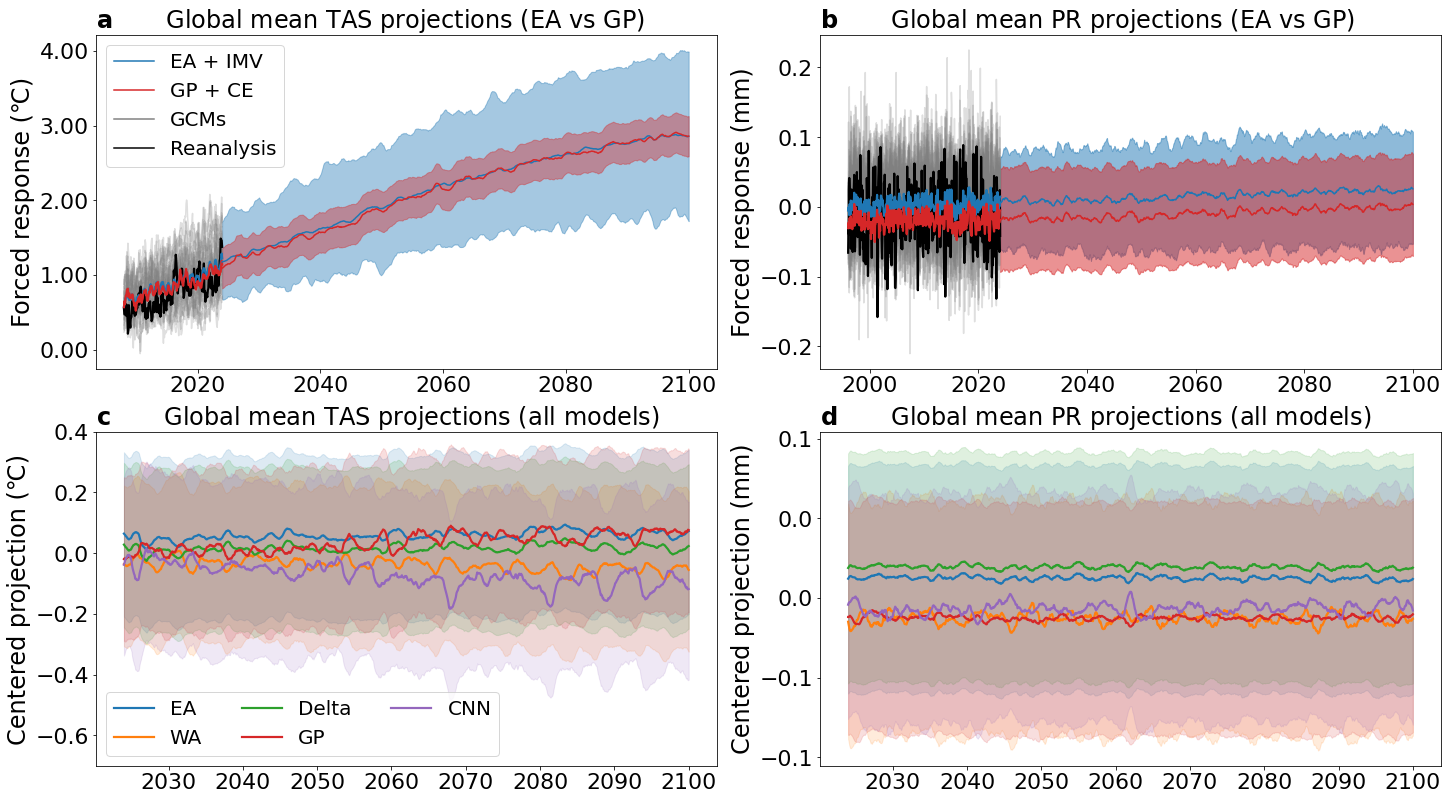

In [32]:
fig = plt.figure(constrained_layout = True, figsize = (20, 11))
gs = GridSpec(2, 2, figure = fig)

lw = 2.2
tas_tval = np.linspace(2008, 2024, 200)
tas_ttest = np.linspace(2024, 2100, 912-11)
pr_tval = np.linspace(1996, 2024, 400)
pr_ttest = np.linspace(2024, 2100, 912-11)

ax = plt.subplot(gs[0, 0])
ax.plot(tas_tval, tas_xval2, c = 'grey', alpha = 0.25)
ax.plot(tas_tval, tas_yval2, c = 'black', linewidth = lw)
ax.plot(tas_tval, np.mean(tas_xval2, axis = 1), c = 'C0', linewidth = lw)
ax.plot(tas_tval, tas_yval_hat2, c = 'C3', linewidth = lw)

ax.plot(tas_ttest, moving_average(np.mean(tas_imv_pred, axis = 1)), c = 'C0')
ax.plot(tas_ttest, moving_average(tas_ytest_hat2), c = 'C3')
ax.fill_between(tas_ttest, moving_average(tas_imv_ub), moving_average(tas_imv_lb), color = 'C0', alpha = 0.4)
ax.fill_between(tas_ttest, moving_average(tas_conf_ub), moving_average(tas_conf_lb), color = 'C3', alpha = 0.4)
ax.set_title(r'$\bf{a}$' + f'       Global mean TAS projections (EA vs GP)', fontsize = 24, loc='left')
ax.set_ylabel('Forced response (\u2103)', fontsize = 24)

ax.plot([], [], c = 'C0', label = 'EA + IMV')
ax.plot([], [], c = 'C3', label = 'GP + CE')
ax.plot([], [], c = 'grey', label = 'GCMs')
ax.plot([], [], c = 'black', label = 'Reanalysis')
ax.legend(fontsize = 20)

ax.yaxis.set_major_formatter('{x:0<4.1f}')
ax.yaxis.set_tick_params(labelsize=22)
ax.xaxis.set_tick_params(labelsize=22)

ax = plt.subplot(gs[0, 1])
ax.plot(pr_tval, pr_xval2, c = 'grey', alpha = 0.25)
ax.plot(pr_tval, pr_yval2, c = 'black', linewidth = lw)
ax.plot(pr_tval, np.mean(pr_xval2, axis = 1), c = 'C0', linewidth = lw)
ax.plot(pr_tval, pr_yval_hat2, c = 'C3', linewidth = lw)

ax.plot(pr_ttest, moving_average(np.mean(pr_imv_pred, axis = 1)), c = 'C0')
ax.plot(pr_ttest, moving_average(pr_ytest_hat2), c = 'C3')
ax.fill_between(pr_ttest, moving_average(pr_imv_ub), moving_average(pr_imv_lb), color = 'C0', alpha = 0.5)
ax.fill_between(pr_ttest, moving_average(pr_conf_ub), moving_average(pr_conf_lb), color = 'C3', alpha = 0.5)
ax.set_title(r'$\bf{b}$' + f'       Global mean PR projections (EA vs GP)', fontsize = 24, loc='left')
ax.set_ylabel('Forced response (mm)', fontsize = 24)

ax.yaxis.set_major_formatter('{x:0<3.1f}')
ax.yaxis.set_tick_params(labelsize=22)
ax.xaxis.set_tick_params(labelsize=22)

### row 2
lw = 2.2
tas_tval = np.linspace(2008, 2024, 200)
tas_ttest = np.linspace(2024, 2100, 912-11)
pr_tval = np.linspace(1996, 2024, 400)
pr_ttest = np.linspace(2024, 2100, 912-11)

tas_center = np.mean(np.stack(tas_preds), axis = 0)
pr_center = np.mean(np.stack(pr_preds), axis = 0)

models = ['EA', 'WA', 'Delta', 'GP', 'CNN']

ax = plt.subplot(gs[1, 0])
for k in range(5):
    tas_ub = moving_average(tas_conf_ubs[k] - tas_center)
    tas_lb = moving_average(tas_conf_lbs[k] - tas_center)
    tas_mu = moving_average(tas_preds[k] - tas_center)
    ax.fill_between(tas_ttest, 
                     tas_ub, 
                     tas_lb, 
                     color = f'C{k}',
                     alpha = 0.15)
    ax.plot(tas_ttest, tas_mu, c =  f'C{k}', label = models[k], linewidth = lw)
    ax.set_title(r'$\bf{c}$' + f'       Global mean TAS projections (all models)', fontsize = 24, loc='left')
    ax.set_ylabel('Centered projection (\u2103)', fontsize = 24)
    ax.yaxis.set_major_formatter('{x:0<3.1f}')
    ax.yaxis.set_tick_params(labelsize=22)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.set_ylim((-0.7, 0.4))
    ax.legend(fontsize = 20, ncol=3)
    

ax = plt.subplot(gs[1, 1])
for k in range(5):
    pr_ub = moving_average(pr_conf_ubs[k] - pr_center)
    pr_lb = moving_average(pr_conf_lbs[k] - pr_center)
    pr_mu = moving_average(pr_preds[k] - pr_center)
    ax.fill_between(pr_ttest, 
                     pr_ub, 
                     pr_lb, 
                     color = f'C{k}',
                     alpha = 0.15)
    ax.plot(pr_ttest, pr_mu, c =  f'C{k}', linewidth = lw)
    ax.set_title(r'$\bf{d}$' + f'       Global mean PR projections (all models)', fontsize = 24, loc='left')
    ax.set_ylabel('Centered projection (mm)', fontsize = 24)
    ax.yaxis.set_major_formatter('{x:0<3.1f}')
    ax.yaxis.set_tick_params(labelsize=22)
    ax.xaxis.set_tick_params(labelsize=22)
plt.show()

In [10]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

tas_reanalysis = np.load('../data/tas_lr_anom.npy')
ytrain_anom = tas_reanalysis
nlat, nlon = ytrain_anom.shape[1:]
mlat, mlon = xtrain_anom.shape[2:]

depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [11]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, nproj, 5, 8])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

_data = scale_and_split(xtrain_anom, xtest_anom, ytrain_anom)

xtrain_scaled = _data[0]
xval_scaled = _data[1]
xtest_scaled = _data[2]
ytrain_scaled = _data[3]
yval_scaled = _data[4]
xtrain_mean = _data[5]
xtest_mean = _data[6]
xtrain_sd = _data[7]
xtest_sd = _data[8]

ntrain = xtrain_scaled.shape[0]
nval = xval_scaled.shape[0]
ntest = xtest_scaled.shape[0]

del _data

In [12]:
tas_conf_ub = []
tas_conf_lb = []
tas_pred = []
for k in [0,1,2,4,5]:

    xval = xtrain_sd[-nval:,None] * xval_scaled + xtrain_mean[-nval:,None]
    yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]
    xtest = xtest_sd[:,None] * xtest_scaled + xtest_mean[:,None]

    yval_hat = np.load(save_loc + f'/yval_{analysis[k]}.npy')
    yval_hat = yval_hat.reshape(-1, nlat, nlon)
    yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
    yval_hat = jnp.float32(jnp.array(yval_hat))

    ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}.npy')
    ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
    ytest_hat = xtest_sd * ytest_hat + xtest_mean
    ytest_hat = jnp.float32(jnp.array(ytest_hat))

    tas_yval = yval
    tas_xval = xval
    tas_xtest = xtest
    tas_yval_hat = yval_hat
    tas_ytest_hat = ytest_hat

    tas_xval2 = np.mean(tas_xval * weight[:,None], axis = (2, 3))
    tas_xtest2 = np.mean(tas_xtest * weight[:,None], axis = (2, 3))
    tas_yval2 = np.mean(tas_yval * weight, axis = (1, 2))
    tas_yval_hat2 = np.mean(tas_yval_hat * weight, axis = (1, 2))
    tas_ytest_hat2 = np.mean(tas_ytest_hat * weight, axis = (1, 2))

    resval = tas_yval2 - tas_yval_hat2
    resval = resval - np.mean(resval)
    tas_conf_ens2 = conformal_ensemble(resval.reshape(-1, 1, 1), depth_fns[0], 0.1).flatten()
    tas_conf_ub.append(np.max(tas_conf_ens2) + tas_ytest_hat2)
    tas_conf_lb.append(np.min(tas_conf_ens2) + tas_ytest_hat2)
    tas_pred.append(tas_ytest_hat2)

In [13]:
nproj = 6
nval = 400

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/pr'

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

# tas_reanalysis = np.load('../data/saved/t2m_obs.npy')
tas_reanalysis = np.load('../data/pr_lr_anom.npy')
ytrain_anom = tas_reanalysis
nlat, nlon = ytrain_anom.shape[1:]
mlat, mlon = xtrain_anom.shape[2:]

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [14]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, nproj, 5, 8])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

_data = scale_and_split(xtrain_anom, xtest_anom, ytrain_anom, nval = 400)

xtrain_scaled = _data[0]
xval_scaled = _data[1]
xtest_scaled = _data[2]
ytrain_scaled = _data[3]
yval_scaled = _data[4]
xtrain_mean = _data[5]
xtest_mean = _data[6]
xtrain_sd = _data[7]
xtest_sd = _data[8]

ntrain = xtrain_scaled.shape[0]
nval = xval_scaled.shape[0]
ntest = xtest_scaled.shape[0]

del _data

In [15]:
pr_conf_ub = []
pr_conf_lb = []
pr_pred = []
for k in [0,1,2,4,5]:

    xval = xtrain_sd[-nval:,None] * xval_scaled + xtrain_mean[-nval:,None]
    yval = xtrain_sd[-nval:] * yval_scaled + xtrain_mean[-nval:]
    xtest = xtest_sd[:,None] * xtest_scaled + xtest_mean[:,None]

    yval_hat = np.load(save_loc + f'/yval_{analysis[k]}.npy')
    yval_hat = yval_hat.reshape(-1, nlat, nlon)
    yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]
    yval_hat = jnp.float32(jnp.array(yval_hat))

    ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}.npy')
    ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
    ytest_hat = xtest_sd * ytest_hat + xtest_mean
    ytest_hat = jnp.float32(jnp.array(ytest_hat))

    pr_yval = yval
    pr_xval = xval
    pr_xtest = xtest
    pr_yval_hat = yval_hat
    pr_ytest_hat = ytest_hat

    pr_xval2 = np.mean(pr_xval * weight[:,None], axis = (2, 3))
    pr_xtest2 = np.mean(pr_xtest * weight[:,None], axis = (2, 3))
    pr_yval2 = np.mean(pr_yval * weight, axis = (1, 2))
    pr_yval_hat2 = np.mean(pr_yval_hat * weight, axis = (1, 2))
    pr_ytest_hat2 = np.mean(pr_ytest_hat * weight, axis = (1, 2))

    resval = pr_yval2 - pr_yval_hat2
    resval = resval - np.mean(resval)
    pr_conf_ens2 = conformal_ensemble(resval.reshape(-1, 1, 1), depth_fns[0], 0.1).flatten()
    pr_conf_ub.append(np.max(pr_conf_ens2) + pr_ytest_hat2)
    pr_conf_lb.append(np.min(pr_conf_ens2) + pr_ytest_hat2)
    pr_pred.append(pr_ytest_hat2)

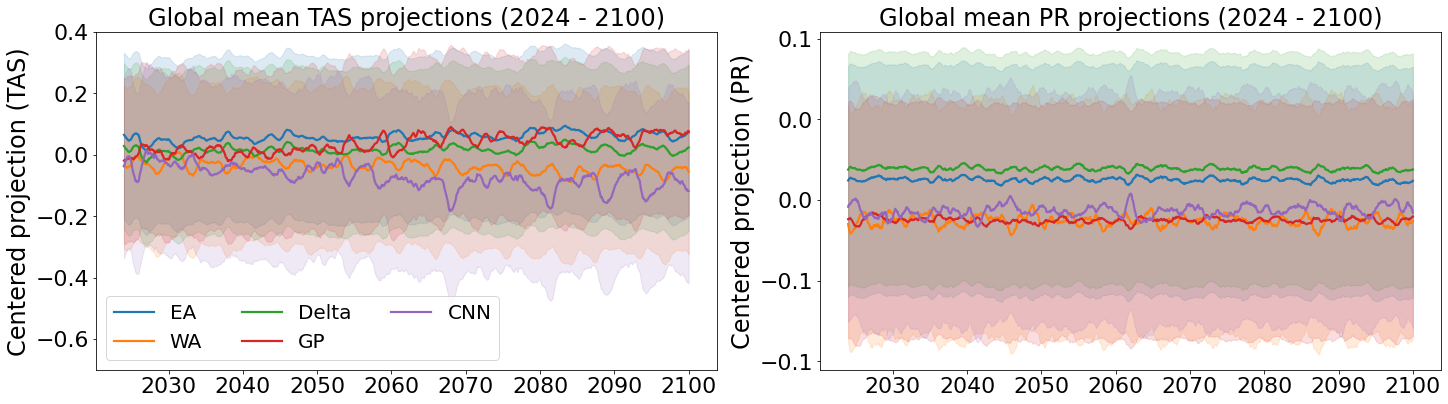

In [66]:
fig = plt.figure(constrained_layout = True, figsize = (20, 5.5))
gs = GridSpec(1, 2, figure = fig)

lw = 2.2
tas_tval = np.linspace(2008, 2024, 200)
tas_ttest = np.linspace(2024, 2100, 912-11)
pr_tval = np.linspace(1996, 2024, 400)
pr_ttest = np.linspace(2024, 2100, 912-11)

tas_center = np.mean(np.stack(tas_pred), axis = 0)
pr_center = np.mean(np.stack(pr_pred), axis = 0)

models = ['EA', 'WA', 'Delta', 'GP', 'CNN']

ax = plt.subplot(gs[0, 0])
for k in range(5):
    tas_ub = moving_average(tas_conf_ub[k] - tas_center)
    tas_lb = moving_average(tas_conf_lb[k] - tas_center)
    tas_mu = moving_average(tas_pred[k] - tas_center)
    ax.fill_between(tas_ttest, 
                     tas_ub, 
                     tas_lb, 
                     color = f'C{k}',
                     alpha = 0.15)
    ax.plot(tas_ttest, tas_mu, c =  f'C{k}', label = models[k], linewidth = lw)
    ax.set_title(f'Global mean TAS projections (2024 - 2100)', fontsize = 24)
    ax.set_ylabel('Centered projection (TAS)', fontsize = 24)
    ax.yaxis.set_major_formatter('{x:0<3.1f}')
    ax.yaxis.set_tick_params(labelsize=22)
    ax.xaxis.set_tick_params(labelsize=22)
    ax.set_ylim((-0.7, 0.4))
    ax.legend(fontsize = 20, ncol=3)
    

ax = plt.subplot(gs[0, 1])
for k in range(5):
    pr_ub = moving_average(pr_conf_ub[k] - pr_center)
    pr_lb = moving_average(pr_conf_lb[k] - pr_center)
    pr_mu = moving_average(pr_pred[k] - pr_center)
    ax.fill_between(pr_ttest, 
                     pr_ub, 
                     pr_lb, 
                     color = f'C{k}',
                     alpha = 0.15)
    ax.plot(pr_ttest, pr_mu, c =  f'C{k}', linewidth = lw)
    ax.set_title(f'Global mean PR projections (2024 - 2100)', fontsize = 24)
    ax.set_ylabel('Centered projection (PR)', fontsize = 24)
    ax.yaxis.set_major_formatter('{x:0<3.1f}')
    ax.yaxis.set_tick_params(labelsize=22)
    ax.xaxis.set_tick_params(labelsize=22)
plt.show()